In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from files.Simulation import Simulation
from files.Source import Source
from files.Observer import Observer
from plot.Trajectory import Trajectory
from plot.Statistics import Statistics

## Simulation setup

#### Parameters

In [3]:
nr_particles = 10**2
nr_steps = 10**4
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
observer_substeps = np.array([False, False, True]) # observe only steps (no substeps)
mfp = np.array([3.75*10**13/4.0, 3.75*10**13/4.0, 7.2*10**13])  # [m]
delta_rho_div_phi = 1 # (delta_r_rho / delta_r_phi)
gyro_radius = 10**11 # [m]; 1pc
all_steps = False

In [4]:
sim = Simulation()

source = Source(gyro_radius, mfp, source_pos, nr_particles)
sim.add_source(source)

observer = Observer(observer_substeps, all_steps)
sim.add_observer(observer)

%time sim.run_simulation(nr_steps)
sim.save_data('data')

start simulation
source
observer
CPU times: user 3.17 s, sys: 47 ms, total: 3.21 s
Wall time: 3.22 s


## Analyze statistics


In [5]:
#from plot.Trajectory import Trajectory

df = pd.read_pickle("data.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
dimensions = 3
sta = Statistics(df_time_evolution_observer, dimensions)
tra = Trajectory(df_time_evolution_observer, dimensions)
particle_ids = tra.get_particle_ids()

init statistics plotting class
init trajectory plotting class


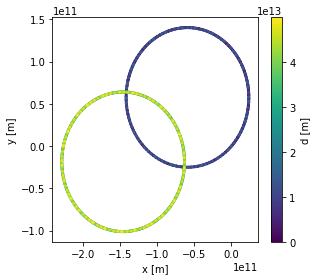

In [6]:
nr_steps = 3*10**4
tra.plot_trajectory('x', 'y', 'd', particle_ids[0], nr_steps, None)

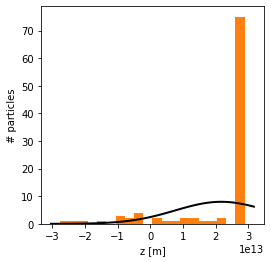

In [7]:
bins = 20
file_name = None
sta.plot_distribution('z', -1, bins, file_name)

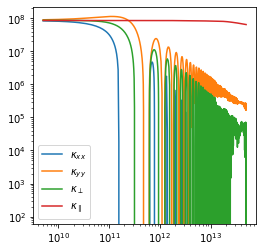

In [8]:
df_kappas = sta.plot_diffusion_coefficients()

In [1]:
df_kappas

NameError: name 'df_kappas' is not defined